In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))


from log_processing import process_log, from_csv

In [20]:
round = 1

a0, t0 = from_csv(round, 0, dir="../../data")
a1, t1 = from_csv(round, 1, dir="../../data")
a2, t2 = from_csv(round, 2, dir="../../data")

In [21]:
PRODUCT = "SQUID_INK"
# Filter activities and trades for the specific product
a0s = a0[a0["product"] == PRODUCT]
t0s = t0[t0["symbol"] == PRODUCT]

a1s = a1[a1["product"] == PRODUCT]
t1s = t1[t1["symbol"] == PRODUCT]

a2s = a2[a2["product"] == PRODUCT]
t2s = t2[t2["symbol"] == PRODUCT]

PRODUCT = "KELP"
# Filter activities and trades for the specific product
a0k = a0[a0["product"] == PRODUCT]
t0k = t0[t0["symbol"] == PRODUCT]

a1k = a1[a1["product"] == PRODUCT]
t1k = t2[t2["symbol"] == PRODUCT]

a2k = a2[a2["product"] == PRODUCT]
t2k = t2[t2["symbol"] == PRODUCT]

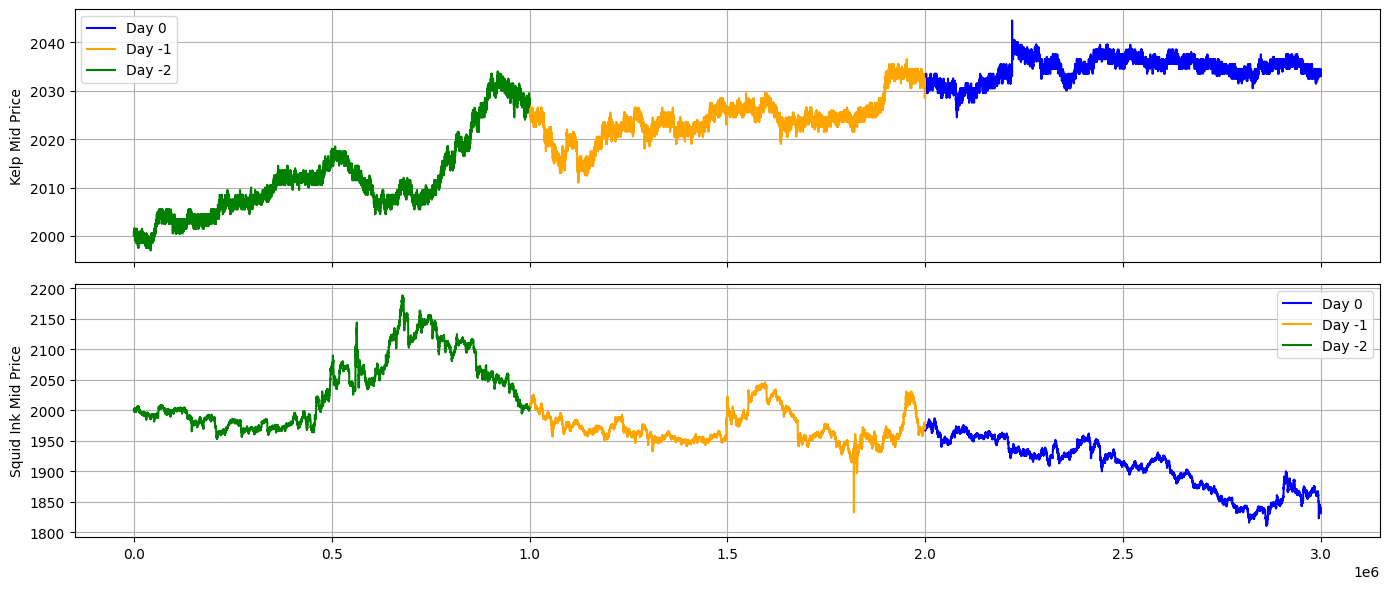

In [22]:

t2 = a2k["timestamp"].values
t1 = a1k["timestamp"].values + t2[-1]
t0 = a0k["timestamp"].values + t1[-1]

midk0 = a0k["mid_price"].values
midk1 = a1k["mid_price"].values
midk2 = a2k["mid_price"].values

mids0 = a0s["mid_price"].values
mids1 = a1s["mid_price"].values
mids2 = a2s["mid_price"].values

# Create a figure with 2 subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
# Plot the mid prices for SQUID_INK
axs[0].plot(t0, midk0, label="Day 0", color="blue")
axs[0].plot(t1, midk1, label="Day -1", color="orange")
axs[0].plot(t2, midk2, label="Day -2", color="green")
axs[0].set_ylabel("Kelp Mid Price")
axs[0].legend()
axs[0].grid()

axs[1].plot(t0, mids0, label="Day 0", color="blue")
axs[1].plot(t1, mids1, label="Day -1", color="orange")
axs[1].plot(t2, mids2, label="Day -2", color="green")
axs[1].set_ylabel("Squid Ink Mid Price")
axs[1].legend()
axs[1].grid()

plt.tight_layout()

In [23]:
t_tot = np.concatenate((t2, t1, t0))
midk_tot = np.concatenate((midk2, midk1, midk0))
mids_tot = np.concatenate((mids2, mids1, mids0))

In [24]:
from scipy import stats

corr, p_value = stats.pearsonr(midk_tot, mids_tot)
print(f"Pearson correlation coefficient: {corr}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: -0.5914885953297089
P-value: 0.0


In [7]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Prepare data for Johansen test
import pandas as pd
data = np.column_stack((midk_tot, mids_tot))
df = pd.DataFrame(data, columns=['midk', 'mids'])

# Determine lag order (simplified)
lag = 0

# Perform Johansen cointegration test
johansen_result = coint_johansen(df, det_order=0, k_ar_diff=lag)

# Print results
trace_stats = johansen_result.lr1
trace_crit = johansen_result.cvt
max_eig_stats = johansen_result.lr2
max_eig_crit = johansen_result.cvm

print("Johansen Cointegration Test Results:")
print("\nTrace Statistics:")
for i, (stat, crit) in enumerate(zip(trace_stats, trace_crit)):
    print(f"r<={i}: {stat:.4f}, Critical Value: {crit[1]:.4f}")
    print(f"{'Reject' if stat > crit[1] else 'Cannot reject'} null hypothesis of r<={i} cointegrating relations")

print("\nMax Eigenvalue Statistics:")
for i, (stat, crit) in enumerate(zip(max_eig_stats, max_eig_crit)):
    print(f"r<={i}: {stat:.4f}, Critical Value: {crit[1]:.4f}")
    print(f"{'Reject' if stat > crit[1] else 'Cannot reject'} null hypothesis of r<={i} cointegrating relations")

Johansen Cointegration Test Results:

Trace Statistics:
r<=0: 75.6034, Critical Value: 15.4943
Reject null hypothesis of r<=0 cointegrating relations
r<=1: 5.6885, Critical Value: 3.8415
Reject null hypothesis of r<=1 cointegrating relations

Max Eigenvalue Statistics:
r<=0: 69.9150, Critical Value: 14.2639
Reject null hypothesis of r<=0 cointegrating relations
r<=1: 5.6885, Critical Value: 3.8415
Reject null hypothesis of r<=1 cointegrating relations


In [8]:
from statsmodels.tsa.stattools import adfuller

# Example interpretation
def interpret_adf(result):
    adf_stat = result[0]
    p_val = result[1]
    crit_vals = result[4]
    
    print(f"ADF Statistic: {adf_stat:.4f}")
    print(f"p-value: {p_val:.4f}")
    print(f"Critical Values:")
    for key, value in crit_vals.items():
        print(f"  {key}: {value:.4f}")
    
    # Interpretation
    if p_val < 0.05:
        print("\nResult: Series is STATIONARY (rejects unit root)")
       
    else:
        print("\nResult: Series is NON-STATIONARY (has unit root)")
   

returnsk = np.diff(midk_tot) / midk_tot[:-1]
returnss = np.diff(mids_tot) / mids_tot[:-1]

# Apply to your results
print("For kelp returns:")
interpret_adf(adfuller(returnsk))

print("\nFor For ink returns:")
interpret_adf(adfuller(returnss))

For kelp returns:
ADF Statistic: -33.6295
p-value: 0.0000
Critical Values:
  1%: -3.4306
  5%: -2.8616
  10%: -2.5668

Result: Series is STATIONARY (rejects unit root)

For For ink returns:
ADF Statistic: -27.6932
p-value: 0.0000
Critical Values:
  1%: -3.4306
  5%: -2.8616
  10%: -2.5668

Result: Series is STATIONARY (rejects unit root)


In [9]:
from statsmodels.tsa.stattools import coint
# Calculate cointegration
score, p_value, _ = coint(midk_tot, mids_tot)
print(f"Cointegration score: {score}")
print(f"P-value: {p_value}")
if p_value < 0.05:
    print("The two series are cointegrated.")
else:
    print("The two series are not cointegrated.")

Cointegration score: -2.7726695787324953
P-value: 0.17453569821901005
The two series are not cointegrated.


Cointegrating vector: [0.11243038 0.01296108]


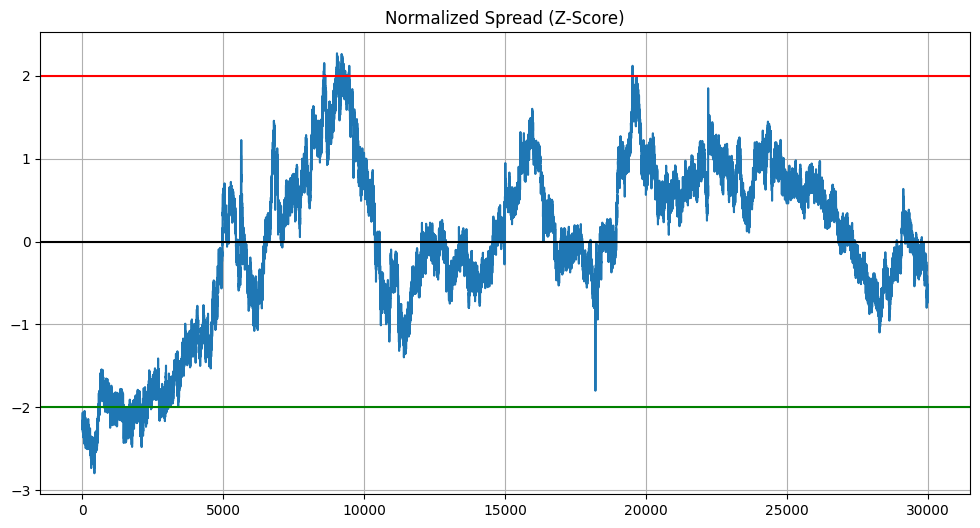

In [10]:
# Extract the first cointegrating vector (weights)
coint_vector = johansen_result.evec[:, 0]
print(f"Cointegrating vector: {coint_vector}")

# Construct the spread
spread = midk_tot * coint_vector[0] + mids_tot * coint_vector[1]

# Normalize for easier interpretation
spread_zscore = (spread - np.mean(spread)) / np.std(spread)

# Visualize
plt.figure(figsize=(12, 6))
plt.plot(spread_zscore)
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='g', linestyle='-')
plt.axhline(y=0, color='k', linestyle='-')
plt.title('Normalized Spread (Z-Score)')
plt.grid(True)
plt.show()

In [11]:
import statsmodels.api as sm    

# Calculate the spread
S1 = sm.add_constant(midk_tot)
S2 = mids_tot
# Fit the regression model
results = sm.OLS(S2, S1).fit()

b = results.params[1]
spread = mids_tot - b * midk_tot

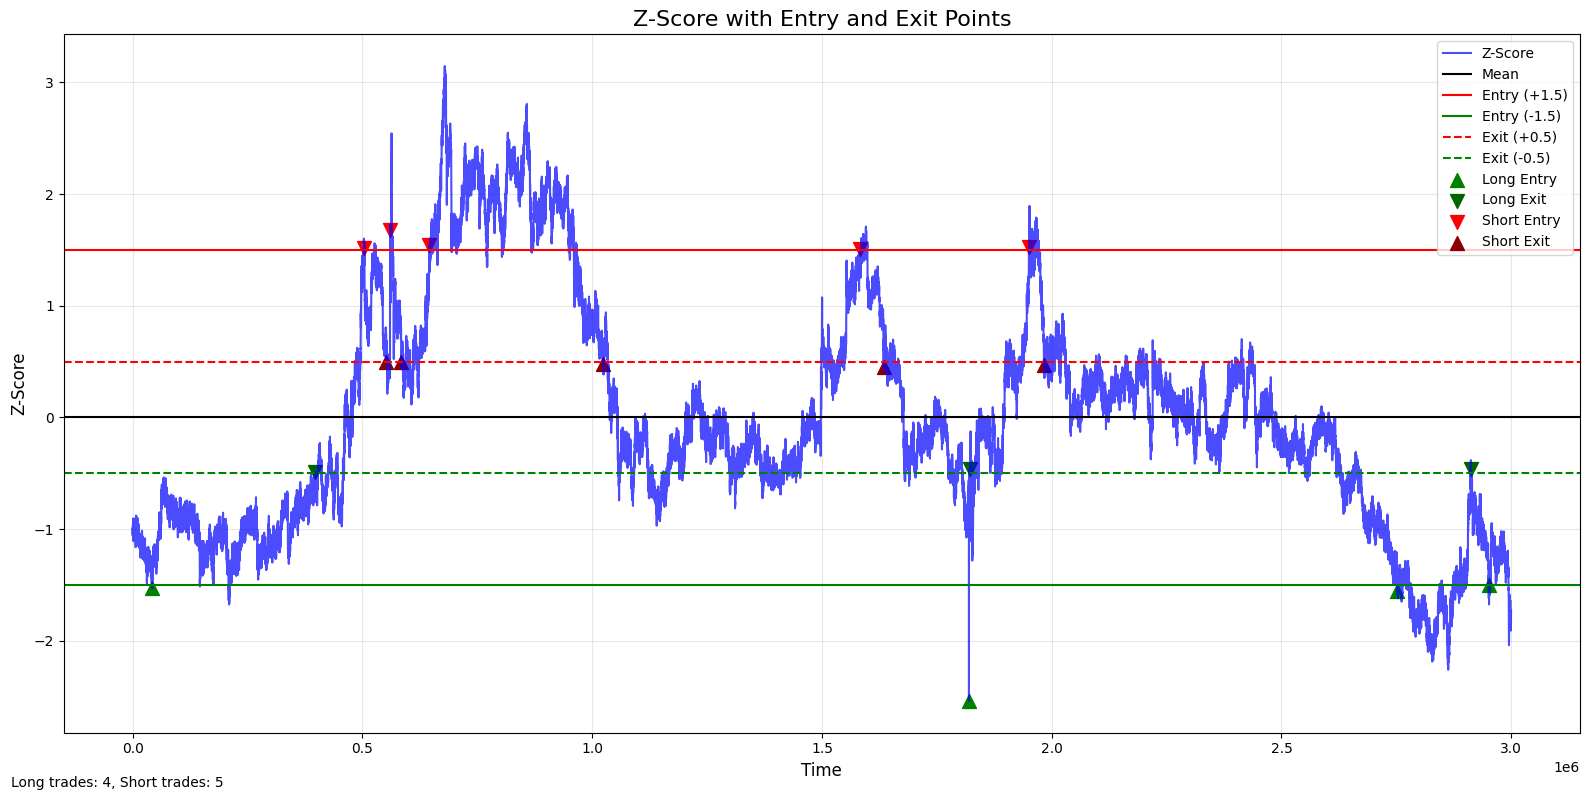

Number of long entries: 4
Number of short entries: 5
Total trades: 9


In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate z-score of the spread (if not already done)
mean_spread = np.mean(spread)
std_spread = np.std(spread)
z_score = (spread - mean_spread) / std_spread

# Define entry and exit thresholds
entry_threshold = 1.5
exit_threshold = 0.5

# Initialize position tracking
position = 0  # 0 = no position, 1 = long spread, -1 = short spread
positions = np.zeros(len(z_score))

# Track entry and exit points
long_entries = []
long_exits = []
short_entries = []
short_exits = []

# Loop through the z-score to identify trade points
for i in range(1, len(z_score)):
    # Check for exit signals first
    if position == 1 and z_score[i] >= -exit_threshold:  # Exit long position
        long_exits.append(i)
        position = 0
    elif position == -1 and z_score[i] <= exit_threshold:  # Exit short position
        short_exits.append(i)
        position = 0
    
    # Check for entry signals
    elif position == 0 and z_score[i] <= -entry_threshold:  # Enter long position
        long_entries.append(i)
        position = 1
    elif position == 0 and z_score[i] >= entry_threshold:  # Enter short position
        short_entries.append(i)
        position = -1
    
    positions[i] = position

# Create the plot
plt.figure(figsize=(16, 8))
plt.plot(t_tot, z_score, label='Z-Score', color='blue', alpha=0.7)

# Add horizontal lines for thresholds
plt.axhline(y=0, color='black', linestyle='-', label='Mean')
plt.axhline(y=entry_threshold, color='red', linestyle='-', label=f'Entry (+{entry_threshold})')
plt.axhline(y=-entry_threshold, color='green', linestyle='-', label=f'Entry (-{entry_threshold})')
plt.axhline(y=exit_threshold, color='red', linestyle='--', label=f'Exit (+{exit_threshold})')
plt.axhline(y=-exit_threshold, color='green', linestyle='--', label=f'Exit (-{exit_threshold})')

# Plot entry and exit points
plt.scatter([t_tot[i] for i in long_entries], [z_score[i] for i in long_entries], 
           color='green', s=100, marker='^', label='Long Entry')
plt.scatter([t_tot[i] for i in long_exits], [z_score[i] for i in long_exits], 
           color='darkgreen', s=100, marker='v', label='Long Exit')
plt.scatter([t_tot[i] for i in short_entries], [z_score[i] for i in short_entries], 
           color='red', s=100, marker='v', label='Short Entry')
plt.scatter([t_tot[i] for i in short_exits], [z_score[i] for i in short_exits], 
           color='darkred', s=100, marker='^', label='Short Exit')

# Add labels and legend
plt.title('Z-Score with Entry and Exit Points', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Z-Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')

# Add trade counts
plt.figtext(0.01, 0.01, 
            f"Long trades: {len(long_entries)}, Short trades: {len(short_entries)}", 
            ha='left', fontsize=10)

plt.tight_layout()
plt.show()

# Print trade summary
print(f"Number of long entries: {len(long_entries)}")
print(f"Number of short entries: {len(short_entries)}")
print(f"Total trades: {len(long_entries) + len(short_entries)}")